In [7]:
pip install qutip

In [10]:
pip install qutip-qip

/usr/local/lib/python3.11/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:1853: ComplexWarning: Casting complex values to real discards the imaginary part
  return affine_transform(values, mtx)



Measurement Probabilities:
|H⟩: 0.5157-0.0000j
|V⟩: 0.4843+0.0000j


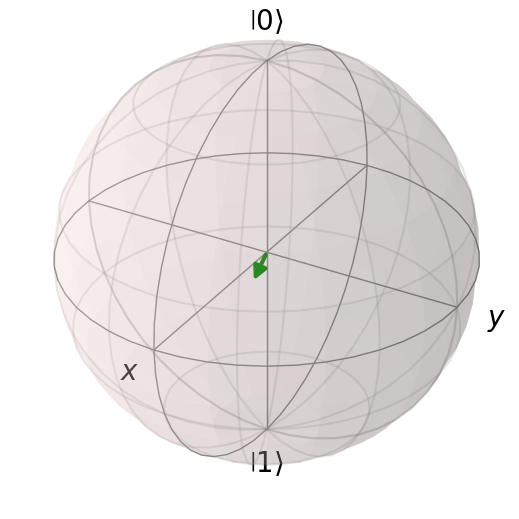

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import (basis, tensor, sigmay, sigmax, sigmaz, Bloch)
from qutip_qip.circuit import QubitCircuit
from qutip_qip.device import Processor
from qutip_qip.noise import RelaxationNoise
from qutip_qip.pulse import Pulse
from qutip_qip.operations import gate_sequence_product

# Define a subclass of Processor to implement OpticalProcessor with required methods
class OpticalProcessor(Processor):
    def __init__(self, N):
        super().__init__(N)
        # Add controls using the proper add_control method
        self.add_control(sigmay(), targets=0, label="HWP_CTRL")
        self.add_control(sigmay(), targets=1, label="HWP_TARGET")
        self.add_control(tensor(sigmaz(), sigmaz()), targets=[0,1], label="PBS")
        self._pulse_dict = {"SNOT": 10, "CNOT": 20}

    def load_circuit(self, qc):
        self.global_phase = 0
        self._time = 0
        self.pulses = []
        gate_times = {"SNOT": 10, "CNOT": 20}
        for gate in qc.gates:
            if gate.name == "SNOT":
                label = "HWP_CTRL" if gate.targets[0] == 0 else "HWP_TARGET"
                pulse = Pulse(
                    sigmax(),
                    targets=gate.targets,
                    coeff=np.array([np.pi/2]),
                    tlist=np.array([self._time, self._time + gate_times["SNOT"]]),
                    label=label
                )
                self.add_pulse(pulse)
                self._time += gate_times["SNOT"]
            elif gate.name == "CNOT":
                pulse = Pulse(
                    tensor(sigmaz(), sigmaz()),
                    targets=[0,1],
                    coeff=np.array([1.0]),
                    tlist=np.array([self._time, self._time + gate_times["CNOT"]]),
                    label="PBS"
                )
                self.add_pulse(pulse)
                self._time += gate_times["CNOT"]

num_qubits = 2
H = basis(2,0)
V = basis(2,1)

qc = QubitCircuit(num_qubits, num_cbits=1)
qc.add_gate("SNOT", targets=[0])
qc.add_gate("SNOT", targets=[1])
qc.add_gate("CNOT", controls=[0], targets=[1])
qc.add_gate("SNOT", targets=[0])
qc.add_gate("SNOT", targets=[1])

processor = OpticalProcessor(num_qubits)
t1 = 1e6
t2 = 0.5e6
processor.add_noise(RelaxationNoise(t1=[t1]*num_qubits, t2=[t2]*num_qubits))

processor.load_circuit(qc)
initial_state = tensor(V, V)

result = processor.run_state(
    initial_state,
    analytical=False,
    solver="mesolve",
    options={"store_states": True},
)

measurement_prob = result.states[-1].ptrace(0).diag()

print("\nMeasurement Probabilities:")
print(f"|H⟩: {measurement_prob[0]:.4f}")
print(f"|V⟩: {measurement_prob[1]:.4f}")

bloch = Bloch()
bloch.add_states(result.states[-1].ptrace(0))
bloch.show()
